In [1]:
import os

from dotenv import find_dotenv, load_dotenv
from rich import print as rprint

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 4 (Generation)"

# Part 4: Generation

![](images/04-generation.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKMy6qbrYoxK6zMiJLaZTEzfSpRYm', 'finish_reason': 'stop', 'logprobs': None}, id='run-d6ba3a93-e962-4ab8-99f0-2f7e12dba1f7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## Load documents

In [7]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [8]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
len(docs)

1

In [9]:
print(docs[0].page_content[:1000])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:

Planning

Subgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.
Reflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.


Memory

Short-term memory: I 

## Split documents

In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
len(splits)

66

## Store documents

In [12]:
from langchain_core.vectorstores import InMemoryVectorStore

In [13]:
vectorstore = InMemoryVectorStore(embeddings)
doc_ids = vectorstore.add_documents(documents=splits)
len(doc_ids), len(vectorstore.store)

(66, 66)

## RAG

In [14]:
from typing import TypedDict

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, StateGraph

In [15]:
rag_prompt_template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:"""
print(rag_prompt_template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [16]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [17]:
class State(TypedDict):
    question: str
    context: list[Document]
    answer: str

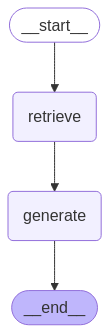

In [18]:
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = format_docs(state["context"])
    rag_prompt = rag_prompt_template.format(
        question=state["question"],
        context=docs_content
    )
    response = llm.invoke([
        HumanMessage(content=rag_prompt)
    ])
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()
graph

In [19]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be achieved through various methods, including prompting a language model, using task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to tackle each component systematically.


In [20]:
# "messages": This streams LLM tokens and metadata for the graph node where LLM is invoked.

for message, metadata in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="messages"):
    print(message.content, end="", flush=True)

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be achieved through various methods, including prompting a language model, using task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to tackle each component systematically.

In [21]:
# "updates": This streams the updates to the state after each step of the graph. If multiple updates are made in the same step (e.g. multiple nodes are run) then those updates are streamed separately.

for event in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    rprint(event)

{
    'retrieve': {
        'context': [
            Document(
                id='dd3910ec-d746-4ac2-8fc5-6338a6680220',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning 
possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple 
thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS 
(depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition
can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving 
XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with 
human inputs.'
            ),
            Document(
                id='16861ca7-7003-48df-9bbc-4fc704de093f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='0c8ac67e-64c0-4b76-b9e7-37e5c80d0627',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", 
task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" 
field denotes the id of the previous task which generates a new resource that the current task relies on. A special
tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The 
task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship 
between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are 
several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From 
this chat history, you can find the path of the user-mentioned resources for your task planning.'
            ),
            Document(
                id='25d35097-35a6-40ea-a9c1-87136f4ae0a9',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe 
system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple
tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use 
few-shot examples to guide LLM to do task parsing and planning.\nInstruction:'
            )
        ]
    }
}

{
    'generate': {
        'answer': "Task decomposition is the process of breaking down a complex task into smaller, manageable steps
or subgoals. This can be achieved through various methods, including prompting a language model, using 
task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to 
tackle each component systematically."
    }
}

In [22]:
for stream_mode, event in graph.stream({"question": "What is Task Decomposition?"}, stream_mode=["messages", "updates"]):
    match stream_mode:
        case "messages":
            message, metadata = event
            print(message.content, end="", flush=True)
        case "updates":
            rprint(event)

{
    'retrieve': {
        'context': [
            Document(
                id='dd3910ec-d746-4ac2-8fc5-6338a6680220',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning 
possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple 
thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS 
(depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition
can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving 
XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with 
human inputs.'
            ),
            Document(
                id='16861ca7-7003-48df-9bbc-4fc704de093f',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: 
Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan 
ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for 
enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more 
test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into 
multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'
            ),
            Document(
                id='0c8ac67e-64c0-4b76-b9e7-37e5c80d0627',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='The AI assistant can parse user input to several tasks: [{"task": task, "id", 
task_id, "dep": dependency_task_ids, "args": {"text": text, "image": URL, "audio": URL, "video": URL}}]. The "dep" 
field denotes the id of the previous task which generates a new resource that the current task relies on. A special
tag "-task_id" refers to the generated text image, audio and video in the dependency task with id as task_id. The 
task MUST be selected from the following options: {{ Available Task List }}. There is a logical relationship 
between tasks, please note their order. If the user input can\'t be parsed, you need to reply empty JSON. Here are 
several cases for your reference: {{ Demonstrations }}. The chat history is recorded as {{ Chat History }}. From 
this chat history, you can find the path of the user-mentioned resources for your task planning.'
            ),
            Document(
                id='25d35097-35a6-40ea-a9c1-87136f4ae0a9',
                metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'},
                page_content='Fig. 11. Illustration of how HuggingGPT works. (Image source: Shen et al. 2023)\nThe 
system comprises of 4 stages:\n(1) Task planning: LLM works as the brain and parses the user requests into multiple
tasks. There are four attributes associated with each task: task type, ID, dependencies, and arguments. They use 
few-shot examples to guide LLM to do task parsing and planning.\nInstruction:'
            )
        ]
    }
}

Task decomposition is the process of breaking down a complex task into smaller, manageable steps or subgoals. This can be achieved through various methods, including prompting a language model, using task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to tackle each component systematically.

{
    'generate': {
        'answer': "Task decomposition is the process of breaking down a complex task into smaller, manageable steps
or subgoals. This can be achieved through various methods, including prompting a language model, using 
task-specific instructions, or incorporating human inputs. It enhances the model's performance by allowing it to 
tackle each component systematically."
    }
}